In [5]:
# !pip install plotly

In [6]:
# !pip install pmdarima

In [7]:
pip install hvplot panel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.1 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import hvplot
import datetime
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import t
from statsmodels.tsa.statespace.varmax import VARMAX
import itertools

In [9]:
import nltk
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("vader_lexicon")

import re
import string
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import panel as pn
pn.extension('plotly')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


**QUESTIONS**:
1. Forecast the YoY performance of three restaurant chains: EAT, DRI, and TXRH
2. Calculate the quarterly YoY % changes in each of the restaurant chain’s transaction data.
3. Formulate an opinion on the quality of each restaurant chain.
4. Are there any fundamental characteristics that separate one of these chains from the others and which companies should you invest in?

# Question 1

### EDA

In [10]:
df_reported_numbers = pd.read_excel("Main Data.xlsx", sheet_name="Reported Numbers")
df_txn_data = pd.read_excel("Main Data.xlsx", sheet_name="Txn Data")
df_panel_data = pd.read_excel("Main Data.xlsx", sheet_name="Panel Stats")
df_review_data = pd.read_excel("Main Data.xlsx", sheet_name="Review Data")

In [11]:
# Create Year-Month column
df_txn_data['Year'] = df_txn_data['optimized_transaction_date'].dt.year
df_txn_data['Month'] = df_txn_data['optimized_transaction_date'].dt.month
df_txn_data['Year-Month'] = df_txn_data['Year'].astype(str) + '-' + df_txn_data['Month'].astype(str).str.zfill(2)
df_txn_data = df_txn_data.drop(["Year","Month"], axis=1)

In [12]:
df_txn_data.head()

,entity,optimized_transaction_date,captured_spend,num_txns,Year-Month
0,TXRH,2016-09-01,143013.36,3380,2016-09
1,TXRH,2016-09-02,236948.62,3980,2016-09
2,TXRH,2016-09-03,42400.80,853,2016-09
3,TXRH,2016-09-04,43738.39,873,2016-09
4,TXRH,2016-09-05,36176.66,752,2016-09


In [13]:
def month_plot_ts(df_txn_data, entity):
    # Agg by Year-Month
    entity_txn = df_txn_data[df_txn_data["entity"] == entity]
    entity_txn_agg = entity_txn[['entity','captured_spend', 'num_txns',
       'Year-Month']].groupby(["Year-Month"]).agg({"entity":"max","captured_spend":"sum","num_txns":"sum"})

    # Create plots for captured spend and number of transactions
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Scatter(x=entity_txn_agg.index,
                             y=entity_txn_agg["captured_spend"],
                             name="Captured Spend"),
                             secondary_y=False)
    fig.add_trace(go.Scatter(x=entity_txn_agg.index,
                             y=entity_txn_agg["num_txns"],
                             name="Number of Transactions"),
                             secondary_y=True)

    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Captured Spend", secondary_y=False)
    fig.update_yaxes(title_text="Number of Transactions", secondary_y=True)
    fig.update_layout(title= entity + " Line Plot", width=800, height=500)

    return fig

In [14]:
plot1 = month_plot_ts(df_txn_data, "TXRH")
plot2 = month_plot_ts(df_txn_data, "DRI")
plot3 = month_plot_ts(df_txn_data, "EAT")

In [15]:
# Create the tabs
tabs = pn.Tabs(
    ("TXRH", plot1),
    ("DRI", plot2),
    ("EAT", plot3))

pn.Column("# Monthly Agg Captured Spend vs. Number of Transactions", tabs)

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Plotly(Figure, name='TXRH')
        [1] Plotly(Figure, name='DRI')
        [2] Plotly(Figure, name='EAT')

In [16]:
df_panel_data.head()

,optimized_transaction_date,num_panelists
0,2016-09-01,3222140
1,2016-09-02,3320069
2,2016-09-03,628425
3,2016-09-04,614634
4,2016-09-05,632600


In [17]:
# Get year-month
df_panel_data['Year'] = df_panel_data['optimized_transaction_date'].dt.year
df_panel_data['Month'] = df_panel_data['optimized_transaction_date'].dt.month
df_panel_data['Year-Month'] = df_panel_data['Year'].astype(str) + '-' + df_panel_data['Month'].astype(str).str.zfill(2)
df_panel_data = df_panel_data.drop(["Year","Month"], axis=1)
df_panel_data_agg = df_panel_data.groupby(["Year-Month"]).agg({"num_panelists":"sum"})

# Agg by Year-Month
txn_agg = df_txn_data[['num_txns','Year-Month']].groupby(["Year-Month"]).agg({"num_txns":"sum"})

# Create plot for number of panelists and number of transactions
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_panel_data_agg.index,
                         y=df_panel_data_agg["num_panelists"],
                         name="Panelists"),
                         secondary_y=False)
fig.add_trace(go.Scatter(x=df_panel_data_agg.index,
                         y=txn_agg["num_txns"],
                         name="Transactions"),
                         secondary_y=True)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Number of Panelists", secondary_y=False)
fig.update_yaxes(title_text="Number of Transactions", secondary_y=True)
fig.update_layout(title= "Panelists and Transactions Over Time", width=800, height=500)

fig.show()

<u> Observations: <u>

This plot is very interesting because the number of panelists (individuals contributing to the provided transaction data) fluctuated during COVID but remained somewhat the same, while the number of transactions took a huge hit. Therefore, it shows that the individuals contributing (or buying food from these restaurants) stayed relatively constant, but were making transactions less frequently.

In [18]:
# This function aggregates the data by quarter, fetches the YoY% sales for each quarter, and splits it into train/test
def train_test(df_txn_data, df_reported_numbers, entity, initial):
    # Get start and end dates for quarters
    dates = list(df_reported_numbers[df_reported_numbers["entity"] == entity].reset_index(drop=True)["period_end_dt"][:-1])
    list_dates = np.concatenate([[initial],dates])
    start = str(dates[-1])[0:10]
    end = str(list(df_reported_numbers[df_reported_numbers["entity"] == entity].reset_index(drop=True)["period_end_dt"])[-1])[0:10]

    # Agg by quarter
    entity_txn = df_txn_data[df_txn_data["entity"] == entity].reset_index(drop=True)
    entity_txn['group'] = ""
    list_dates = [dt.strftime('%Y-%m-%d') for dt in dates]
    list_dates.insert(0, initial)
    list_dates = [datetime.datetime.strptime(date_str, "%Y-%m-%d") for date_str in list_dates]

    for i in range(len(list_dates)-1):
        for j in range(len(entity_txn)):
            if entity_txn["optimized_transaction_date"][j] > list_dates[i] and entity_txn["optimized_transaction_date"][j] <= list_dates[i+1]:
                entity_txn["group"][j] = i

    entity_txn_agg_group = entity_txn[['entity', 'optimized_transaction_date', 'captured_spend', 'num_txns',
       'group']].groupby(["group"]).agg({"entity":"max", "optimized_transaction_date":"count",
                                                   "captured_spend":"sum","num_txns":"sum"})
    #print(entity_txn_agg_group)
    entity_txn_agg_group = entity_txn_agg_group[(entity_txn_agg_group.index != "")]

    # Merge YoY sales % column
    reported_num = df_reported_numbers[df_reported_numbers["entity"] == entity].reset_index(drop=True)
    reported_num = reported_num.dropna()
    df_merge = entity_txn_agg_group.merge(reported_num[["period_end_dt","reported_sales_yoy"]],
                                            how="left",
                                            right_on=reported_num.index,
                                            left_on=entity_txn_agg_group.index)
    # Split into train and test
    df_train = df_merge.copy()

    df_train["spend_per_txn"] = df_train["captured_spend"] / df_train["num_txns"]
    df_train["reported_sales_yoy"] = df_train["reported_sales_yoy"] * 100

    df_train = df_train.drop("key_0", axis=1)

    test = entity_txn[(entity_txn["optimized_transaction_date"] > start)&
                      (entity_txn["optimized_transaction_date"] <= end)]

    df_test = pd.DataFrame(index=[0])
    df_test["entity"] = entity
    df_test["optimized_transaction_date"] = len(test)
    df_test["period_end_dt"] = end
    df_test["captured_spend"] = test["captured_spend"].sum()
    df_test["num_txns"] = test["num_txns"].sum()

    return df_train, df_test

In [19]:
df_train_txrh, df_test_txrh = train_test(df_txn_data, df_reported_numbers, "TXRH", "2017-06-26")
df_train_dri, df_test_dri = train_test(df_txn_data, df_reported_numbers, "DRI", "2017-02-28")
df_train_eat, df_test_eat = train_test(df_txn_data, df_reported_numbers, "EAT", "2017-06-27")


Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-7b79e1121644>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-7b79e1121644>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-7b79e1121644>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<i

In [20]:
df_train_eat

,entity,optimized_transaction_date,captured_spend,num_txns,period_end_dt,reported_sales_yoy,spend_per_txn
0,EAT,92,27071503.56,715060,2017-09-27,-2.775661,37.859066
1,EAT,91,27966381.18,737471,2017-12-27,-0.804184,37.922008
2,EAT,91,30109029.17,796121,2018-03-28,-0.016316,37.819665
3,EAT,91,30824215.23,808450,2018-06-27,0.706890,38.127547
4,EAT,91,28065084.39,750434,2018-09-26,1.584229,37.398471
5,EAT,91,29328794.76,770174,2018-12-26,2.532961,38.080739
6,EAT,91,31047830.14,816760,2019-03-27,2.669846,38.013407
7,EAT,91,31601785.33,811359,2019-06-26,1.746586,38.949202
8,EAT,91,29919162.31,778724,2019-09-25,4.919216,38.420753
9,EAT,91,31369851.30,811103,2019-12-25,11.354575,38.675546


In [21]:
# This function creates quarterly plots, specifically 1) captured spend and number of transactions vs. time,
# 2) captured spend and YoY sales % vs. time, 3) spend per transaction and YoY sales % vs. time

def quarter_plot_ts(df_train, entity):
    # Create a subplot with two y-axes
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(go.Scatter(x=df_train["period_end_dt"],
                             y=df_train["captured_spend"],
                             name="Captured Spend"),
                             secondary_y=False)
    fig.add_trace(go.Scatter(x=df_train["period_end_dt"],
                             y=df_train["num_txns"],
                             name="Number of Transactions"),
                             secondary_y=True)

    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Captured Spend", secondary_y=False)
    fig.update_yaxes(title_text="Number of Transactions", secondary_y=True)
    fig.update_layout(title= entity + " Captured Spend and Number of Transactions", width=800, height=500)


    # Create a subplot with two y-axes
    fig2 = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig2.add_trace(go.Scatter(x=df_train["period_end_dt"],
                             y=df_train["captured_spend"],
                             name="Captured Spend"),
                             secondary_y=False)
    fig2.add_trace(go.Scatter(x=df_train["period_end_dt"],
                             y=df_train["reported_sales_yoy"],
                             name="YoY Sales Percentage"),
                             secondary_y=True)

    fig2.update_xaxes(title_text="Date")
    fig2.update_yaxes(title_text="Captured Spend", secondary_y=False)
    fig2.update_yaxes(title_text="YoY Sales Percentage", secondary_y=True)
    fig2.update_layout(title= entity + " Captured Spend and YoY Sales Percentage", width=800, height=500)


    # Create a subplot with two y-axes
    fig3 = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig3.add_trace(go.Scatter(x=df_train["period_end_dt"],
                             y=df_train["spend_per_txn"],
                             name="spend per txn"),
                             secondary_y=False)
    fig3.add_trace(go.Scatter(x=df_train["period_end_dt"],
                             y=df_train["reported_sales_yoy"],
                             name="YoY Sales Percentage"),
                             secondary_y=True)

    fig3.update_xaxes(title_text="Date")
    fig3.update_yaxes(title_text="Captured Spend", secondary_y=False)
    fig3.update_yaxes(title_text="YoY Sales Percentage", secondary_y=True)
    fig3.update_layout(title= entity + " Spend per Transaction and YoY Sales Percentage", width=800, height=500)


    return fig, fig2, fig3

In [22]:
plot1a, plot1b, plot1c = quarter_plot_ts(df_train_txrh, "TXRH")
plot2a, plot2b, plot2c = quarter_plot_ts(df_train_dri, "DRI")
plot3a, plot3b, plot3c = quarter_plot_ts(df_train_eat, "EAT")

In [23]:
# Create the tabs
tabs = pn.Tabs(
    ("TXRH", pn.Tabs(("Captured Spend and Number of Transactions",plot1a),
                     ("Captured Spend and YoY Sales Percentage",plot1b),
                     ("Spend per Transaction and YoY Sales Percentage",plot1c))),
    ("DRI", pn.Tabs(("Captured Spend and Number of Transactions",plot2a),
                     ("Captured Spend and YoY Sales Percentage",plot2b),
                     ("Spend per Transaction and YoY Sales Percentage",plot2c))),
    ("EAT", pn.Tabs(("Captured Spend and Number of Transactions",plot3a),
                     ("Captured Spend and YoY Sales Percentage",plot3b),
                     ("Spend per Transaction and YoY Sales Percentage",plot3c))))

pn.Column("# Quarter Agg Plots", tabs)

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Tabs
            [0] Plotly(Figure, name='Captured Spend a...)
            [1] Plotly(Figure, name='Captured Spend a...)
            [2] Plotly(Figure, name='Spend per Transaction a...)
        [1] Tabs
            [0] Plotly(Figure, name='Captured Spend a...)
            [1] Plotly(Figure, name='Captured Spend a...)
            [2] Plotly(Figure, name='Spend per Transaction a...)
        [2] Tabs
            [0] Plotly(Figure, name='Captured Spend a...)
            [1] Plotly(Figure, name='Captured Spend a...)
            [2] Plotly(Figure, name='Spend per Transaction a...)

<u> Observations: <u>

1. The captured spend and number of transactions generally follow each other (similar trends)
2. There is seasonality in the captured spend data (In Q2 --> highest peak and Q3 --> lowest peak)
3. The captured spend and YoY sales % don't seem to have any correlation until COVID hits (both curves start to exhibit similar trends)
4. The spend per transaction increases over time, which makes sense (inflation). In addition, it increases quite a bit during COVID probably because they had to increase prices to compensate for their decrease in YoY sales %. The number of transactions also took a huge hit, but the average value of those transactions were higher than before.

### Linear Regression

<u> Reasoning: <u>
    
I wanted to pick a simple model to implement and figure out how to improve my results from that point onwards. Linear regression is also easy to explain since we can look at the coefficients and determine which factors are more impactful on predicting the YoY sales %.

In [24]:
#from sklearn.linear_model import Ridge
def linreg(df_train, df_test):
    df_train['year'] = df_train['period_end_dt'].dt.year
    df_train['month'] = df_train['period_end_dt'].dt.month
    df_train['day'] = df_train['period_end_dt'].dt.day

    df_test["period_end_dt"] = pd.to_datetime(df_test["period_end_dt"])
    df_test['year'] = df_test['period_end_dt'].dt.year
    df_test['month'] = df_test['period_end_dt'].dt.month
    df_test['day'] = df_test['period_end_dt'].dt.day

    model = LinearRegression()
    #model = Ridge(alpha=0.2)
    result = model.fit(df_train[["captured_spend","num_txns","year","month","day"]],
                       df_train["reported_sales_yoy"])

    y_prediction = model.predict(df_test[["captured_spend","num_txns","year","month","day"]])

    # Standard errors of the model coefficients
    n = len(df_train)
    p = len(model.coef_)  #
    print(str(df_train["entity"][0])+" coefficients: " + str(model.coef_))

    # Residuals
    y_pred = model.predict(df_train[["captured_spend", "num_txns", "year", "month", "day"]])
    residuals = df_train["reported_sales_yoy"] - y_pred

    # Standard error of residuals
    se_residuals = np.std(residuals, ddof=p)

    # Degrees of freedom
    df = n - p - 1

    # Find the t-value
    alpha = 0.05
    t_score = stats.t.ppf(1 - alpha / 2, df)  # Two-tailed test

    # Prediction interval
    margin_of_error = t_score * se_residuals
    lower_bound = y_prediction - margin_of_error
    upper_bound = y_prediction + margin_of_error

    # rmse
    rmse = np.sqrt(mean_squared_error(df_train["reported_sales_yoy"], y_pred))

    return y_prediction[0], lower_bound[0], upper_bound[0], rmse

In [25]:
y_pred_txrh, lower_txrh, upper_txrh, rmse_txrh = linreg(df_train_txrh, df_test_txrh)
y_pred_dri, lower_dri, upper_dri, rmse_dri = linreg(df_train_dri, df_test_dri)
y_pred_eat, lower_eat, upper_eat, rmse_eat = linreg(df_train_eat, df_test_eat)

TXRH coefficients: [ 3.35495371e-06  5.34635453e-05 -1.67970438e+01  9.76893861e-02
  5.65384522e-02]
DRI coefficients: [ 2.23698333e-06 -3.43273880e-05 -1.35758741e+01 -6.03377082e-01
 -3.53568978e+00]
EAT coefficients: [-5.66608839e-06  3.88052314e-04 -3.49645786e+00  2.36313939e-01
 -4.29850309e+00]


<u> Observations: <u>

As we can see here, the "year" column has the highest coefficient out of all the coefficients shown above. This means it has the highest impact on predicting the YoY sales %. In addition, as we expected before, the captured spend and number of transactions have little to no impact on the model. Therefore, if we had additional data that tends to be better correlated with YoY sales %, we can arrive at better conclusions.

In [26]:
def viz_plot(df_train, df_test, y_prediction, lower_bound, upper_bound):
    # Create a subplot with two y-axes
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Historical data
    fig.add_trace(go.Scatter(x=df_train["period_end_dt"], y=df_train['reported_sales_yoy'],
                             mode='lines', name='Historical Data', line=dict(color='blue')),
                 secondary_y=False)

    # Forecasted data
    forecast_dates = [df_train["period_end_dt"].iloc[-1], df_test["period_end_dt"].iloc[0]]
    forecast_values_plot = [df_train["reported_sales_yoy"].iloc[-1], y_prediction]
    fig.add_trace(go.Scatter(x=forecast_dates, y=forecast_values_plot, mode='lines',
                        name='Forecasted Data', line=dict(color='red')),
                 secondary_y=False)

    forecast_dates = [df_train["period_end_dt"].iloc[-1], df_test["period_end_dt"].iloc[0]]
    forecast_values_plot = [df_train["reported_sales_yoy"].iloc[-1], lower_bound]
    fig.add_trace(go.Scatter(x=forecast_dates, y=forecast_values_plot, mode='lines',
                        name='Forecasted Data (Lower Bound)', line=dict(color='green', dash='dot')),
                 secondary_y=False)

    forecast_dates = [df_train["period_end_dt"].iloc[-1], df_test["period_end_dt"].iloc[0]]
    forecast_values_plot = [df_train["reported_sales_yoy"].iloc[-1], upper_bound]
    fig.add_trace(go.Scatter(x=forecast_dates, y=forecast_values_plot, mode='lines',
                        name='Forecasted Data (Upper Bound)', line=dict(color='green', dash='dot')),
                 secondary_y=False)

    # Actual data
    df_all = pd.concat([df_train, df_test])
    fig.add_trace(go.Scatter(x=df_all["period_end_dt"], y=df_all["captured_spend"], mode='lines',
                        name='Captured Spend', line=dict(color='black')),
                 secondary_y=True)

    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Reported Sales YoY", secondary_y=False)
    fig.update_yaxes(title_text="Captured Spend", secondary_y=True)

    # Create the layout
    fig.update_layout(title='Historical and Forecasted Data', xaxis=dict(title='Date'), width=800, height=500)

    return fig


In [27]:
linreg_1 = viz_plot(df_train_txrh, df_test_txrh, y_pred_txrh, lower_txrh, upper_txrh)
linreg_2 = viz_plot(df_train_dri, df_test_dri, y_pred_dri, lower_dri, upper_dri)
linreg_3 = viz_plot(df_train_eat, df_test_eat, y_pred_eat, lower_eat, upper_eat)

In [28]:
# Create the tabs
tabs = pn.Tabs(
    ("TXRH", linreg_1),
    ("DRI", linreg_2),
    ("EAT", linreg_3))

pn.Column("# Linear Regression Historical and Forecasted Data", tabs)

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Plotly(Figure, name='TXRH')
        [1] Plotly(Figure, name='DRI')
        [2] Plotly(Figure, name='EAT')

### ARIMA (Auto Regressive Integrated Moving Average)

<u> Reasoning: <u>

This model is commonly used for time series analysis. Mainly used for univariate time series analysis, but can extend it to include exogeneous factors in the model.

In [29]:
## Check for stationarity
print("TXRH p-value: " + str(round(adfuller(df_train_txrh["reported_sales_yoy"])[1],4)))
print("DRI p-value: " + str(round(adfuller(df_train_dri["reported_sales_yoy"])[1],4)))
print("EAT p-value: " + str(round(adfuller(df_train_eat["reported_sales_yoy"])[1],4)))

TXRH p-value: 0.0137
DRI p-value: 1.0
EAT p-value: 0.134


In [30]:
## Differencing if needed
df_train_dri["diff_1"] = df_train_dri["reported_sales_yoy"].diff()
print("DRI p-value: " + str(round(adfuller(df_train_dri["diff_1"].dropna())[1],4)))
df_train_dri["diff_2"] = df_train_dri["diff_1"].diff()
print("DRI p-value: " + str(round(adfuller(df_train_dri["diff_2"].dropna())[1],4)))

df_train_eat["diff_1"] = df_train_eat["reported_sales_yoy"].diff()
print("EAT p-value: " + str(round(adfuller(df_train_eat["diff_1"].dropna())[1],4)))
df_train_eat["diff_2"] = df_train_eat["diff_1"].diff()
print("EAT p-value: " + str(round(adfuller(df_train_eat["diff_2"].dropna())[1],4)))

DRI p-value: 0.3603
DRI p-value: 0.7297
EAT p-value: 0.096
EAT p-value: 0.0


In [31]:
# fig, ax1 = plt.subplots(figsize=(5, 3))
# sm.graphics.tsa.plot_acf(df_train_txrh["reported_sales_yoy"], lags=5, ax=ax1)
# ax1.set_title("ACF Plot")

# fig, ax2 = plt.subplots(figsize=(5, 3))
# sm.graphics.tsa.plot_pacf(df_train_txrh["reported_sales_yoy"], lags=5, ax=ax2)
# ax2.set_title("PACF Plot")

# plt.show()


In [32]:
ACF_txrh, ax1 = plt.subplots(figsize=(4, 2))
sm.graphics.tsa.plot_acf(df_train_txrh["reported_sales_yoy"], lags=5, ax=ax1)
ax1.set_title("ACF Plot")

PACF_txrh, ax1 = plt.subplots(figsize=(4, 2))
sm.graphics.tsa.plot_pacf(df_train_txrh["reported_sales_yoy"], lags=5, ax=ax1)
ax1.set_title("PACF Plot")

plt.close(ACF_txrh)
plt.close(PACF_txrh)

ACF_dri, ax1 = plt.subplots(figsize=(4, 2))
sm.graphics.tsa.plot_acf(df_train_dri["diff_2"].dropna(), lags=4, ax=ax1)
ax1.set_title("ACF Plot")

PACF_dri, ax1 = plt.subplots(figsize=(4, 2))
sm.graphics.tsa.plot_pacf(df_train_dri["diff_2"].dropna(), lags=4, ax=ax1)
ax1.set_title("PACF Plot")

plt.close(ACF_dri)
plt.close(PACF_dri)

ACF_eat, ax1 = plt.subplots(figsize=(4, 2))
sm.graphics.tsa.plot_acf(df_train_eat["diff_2"].dropna(), lags=4, ax=ax1)
ax1.set_title("ACF Plot")

PACF_eat, ax1 = plt.subplots(figsize=(4, 2))
sm.graphics.tsa.plot_pacf(df_train_eat["diff_2"].dropna(), lags=4, ax=ax1)
ax1.set_title("PACF Plot")

plt.close(ACF_eat)
plt.close(PACF_eat)

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Tabs
            [0] Matplotlib(Figure, name='ACF')
            [1] Matplotlib(Figure, name='PACF')
        [1] Tabs
            [0] Matplotlib(Figure, name='ACF')
            [1] Matplotlib(Figure, name='PACF')
        [2] Tabs
            [0] Matplotlib(Figure, name='ACF')
            [1] Matplotlib(Figure, name='PACF')
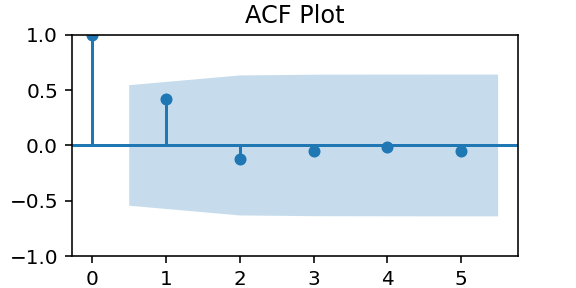
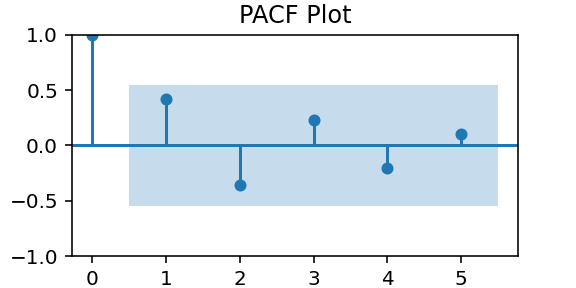
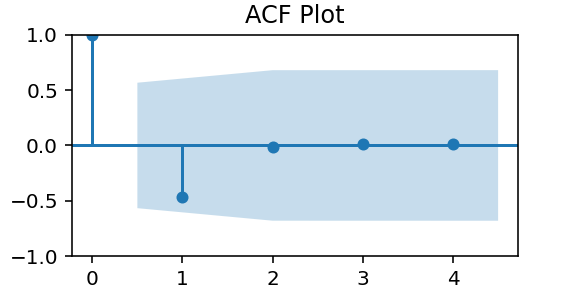
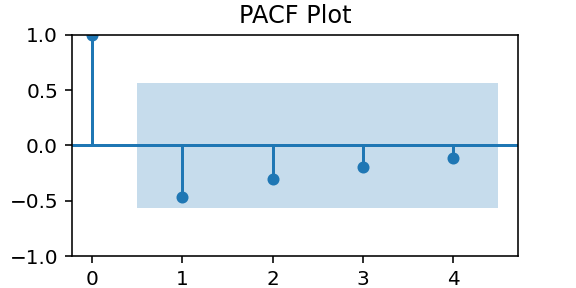
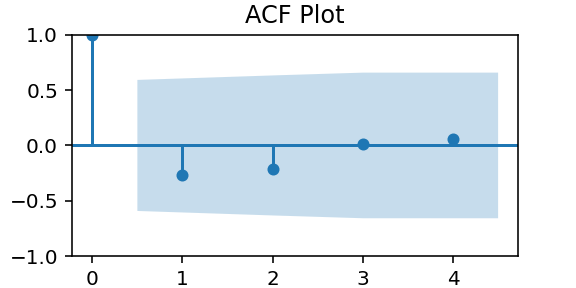
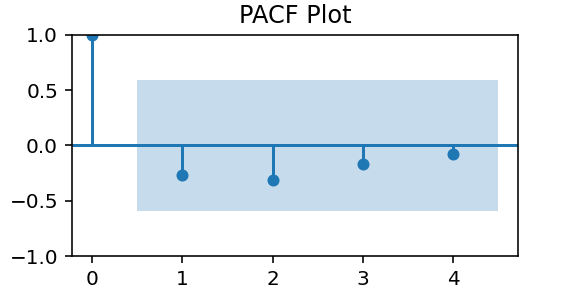

In [33]:
# Create the tabs
tabs = pn.Tabs(
    ("TXRH", pn.Tabs(("ACF", ACF_txrh),
                      ("PACF", PACF_txrh))),
    ("DRI", pn.Tabs(("ACF", ACF_dri),
                      ("PACF", PACF_dri))),
    ("EAT", pn.Tabs(("ACF", ACF_eat),
                      ("PACF", PACF_eat))))

pn.Column("# ARIMA ACF and PACF", tabs)

In [34]:
def arima(p, d, q, df_train):
    # Fit the ARIMAX model
    order = (p, d, q)
    #exog_variables = df_train[["captured_spend","num_txns"]]
    model = sm.tsa.ARIMA(df_train["reported_sales_yoy"], order=order)#, exog=exog_variables)
    results = model.fit()

    # Check model residuals
    residuals = results.resid
    # in_sample_forecasts = results.predict(start=0, end=len(df_train)-1, typ='levels')
    # residuals = df_train["reported_sales_yoy"] - in_sample_forecasts
    # print(residuals)
    fig, ax = plt.subplots(1, 2)
    residuals.plot(title='Residuals', ax=ax[0])
    residuals.plot(title='Density', kind='kde', ax=ax[1])
    plt.close(fig)
    #plt.show()

    # Make a forecast
    #exog_variables_new = df_test[['captured_spend','num_txns']]
    forecast_values = results.forecast(steps=1)#, exog=exog_variables_new)

    # Get the uncertainty/standard error
    forecast_std_error = np.std(residuals)

    # Confidence interval (95% CI)
    alpha = 0.05
    t_score = t.ppf(1 - alpha / 2, df=len(residuals) - 1)  # T-score for 95% confidence interval

    # Margin of error
    margin_of_error = t_score * forecast_std_error

    # Lower and upper bounds
    lower_bound = round(forecast_values[len(df_train)] - margin_of_error, 4)
    upper_bound = round(forecast_values[len(df_train)] + margin_of_error, 4)

    return forecast_values[len(df_train)], lower_bound, upper_bound

In [35]:
def arimax(p, d, q, df_train, df_test):
    # Fit the ARIMAX model
    order = (p, d, q)
    exog_variables = df_train[["captured_spend","num_txns"]]
    model = sm.tsa.ARIMA(df_train["reported_sales_yoy"], order=order, exog=exog_variables)
    results = model.fit()

    # Check model residuals
    residuals = results.resid
    # in_sample_forecasts = results.predict(start=0, end=len(df_train)-1, typ='levels')
    # residuals = df_train["reported_sales_yoy"] - in_sample_forecasts
    # print(residuals)
    fig, ax = plt.subplots(1, 2)
    residuals.plot(title='Residuals', ax=ax[0])
    residuals.plot(title='Density', kind='kde', ax=ax[1])
    plt.close(fig)
    #plt.show()

    # Make a forecast
    exog_variables_new = df_test[['captured_spend','num_txns']]
    forecast_values = results.forecast(steps=1, exog=exog_variables_new)

    # Get the uncertainty/standard error
    forecast_std_error = np.std(residuals)

    # Calculate the confidence interval (95% CI)
    alpha = 0.05
    t_score = t.ppf(1 - alpha / 2, df=len(residuals) - 1)

    # Margin of error
    margin_of_error = t_score * forecast_std_error

    # Lower and upper bounds
    lower_bound = round(forecast_values[len(df_train)] - margin_of_error, 4)
    upper_bound = round(forecast_values[len(df_train)] + margin_of_error, 4)

    return forecast_values[len(df_train)], lower_bound, upper_bound

In [36]:
arimax_pred_txrh, arimax_lower_txrh, arimax_upper_txrh = arimax(1, 0, 0, df_train_txrh, df_test_txrh)
arimax_1 = viz_plot(df_train_txrh, df_test_txrh, arimax_pred_txrh, arimax_lower_txrh, arimax_upper_txrh)

arimax_pred_dri, arimax_lower_dri, arimax_upper_dri = arimax(1, 1, 0, df_train_dri, df_test_dri)
arimax_2 = viz_plot(df_train_dri, df_test_dri, arimax_pred_dri, arimax_lower_dri, arimax_upper_dri)

arimax_pred_eat, arimax_lower_eat, arimax_upper_eat = arimax(1, 0, 0, df_train_eat, df_test_eat)
arimax_3 = viz_plot(df_train_eat, df_test_eat, arimax_pred_eat, arimax_lower_eat, arimax_upper_eat)

arima_pred_txrh_b, arima_lower_txrh_b, arima_upper_txrh_b = arima(1, 0, 0, df_train_txrh)
arima_1_b = viz_plot(df_train_txrh, df_test_txrh, arima_pred_txrh_b, arima_lower_txrh_b, arima_upper_txrh_b)

arima_pred_dri_b, arima_lower_dri_b, arima_upper_dri_b = arima(1, 1, 0, df_train_dri)
arima_2_b = viz_plot(df_train_dri, df_test_dri, arima_pred_dri_b, arima_lower_dri_b, arima_upper_dri_b)

arima_pred_eat_b, arima_lower_eat_b, arima_upper_eat_b = arima(1, 0, 0, df_train_eat)
arima_3_b = viz_plot(df_train_eat, df_test_eat, arima_pred_eat_b, arima_lower_eat_b, arima_upper_eat_b)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [37]:
## when I set d=2 for DRI, it says "Non-stationary starting AR parameters found" --> changed d=1
## when I set d=1 for EAT, it says "Non-stationary starting AR parameters found" --> changed d=0

In [38]:
# Create the tabs
tabs = pn.Tabs(
    ("TXRH", pn.Tabs(("ARIMA",arima_1_b),("ARIMAX", arimax_1))),
    ("DRI", pn.Tabs(("ARIMA",arima_2_b),("ARIMAX", arimax_2))),
    ("EAT", pn.Tabs(("ARIMA",arima_3_b),("ARIMAX", arimax_3))))

pn.Column("# ARIMAX Plots", tabs)

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Tabs
            [0] Plotly(Figure, name='ARIMA')
            [1] Plotly(Figure, name='ARIMAX')
        [1] Tabs
            [0] Plotly(Figure, name='ARIMA')
            [1] Plotly(Figure, name='ARIMAX')
        [2] Tabs
            [0] Plotly(Figure, name='ARIMA')
            [1] Plotly(Figure, name='ARIMAX')

In [39]:
#pm.auto_arima(df_train_dri["reported_sales_yoy"], stepwise=True, seasonal=True)

In [40]:
# import numpy as np
# import pandas as pd
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
# gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
# gpr.fit(df_train_dri[["captured_spend","num_txns","year","month","day"]], df_train_dri["reported_sales_yoy"])
# y_pred, sigma = gpr.predict(df_test_dri[["captured_spend","num_txns","year","month","day"]], return_std=True)
# y_pred

In [41]:
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
# model.fit(df_train_txrh[["captured_spend", "num_txns", "year", "month", "day"]], df_train_txrh["reported_sales_yoy"])
# y_rf = model.predict(df_test_txrh[["captured_spend", "num_txns", "year", "month", "day"]])

### VAR (Vector Auto Regressive)

<u> Reasoning: <u>
    
Even tho VAR can't specify a specific target variable, I wanted to see how well it would do if it takes into account all 3 time series columns that were provided (captured spend, number of transactions, and YoY sales %).

In [42]:
def var(df_train, entity):
    # Define the range of p and q values (automated hyperparameter selection method)
    p_values = range(0, 3)
    q_values = range(0, 3)

    #pq_combinations = list(itertools.product(p_values, q_values))

    best_aic = float("inf")
    best_order = None

    # Iterate through the combinations and fit VARMAX models
    for p in p_values:
        for q in q_values:
            #p, q = pq
            try:
                model = sm.tsa.VARMAX(df_train[['reported_sales_yoy', 'captured_spend', 'num_txns']],
                                      order=(p, q))
                results = model.fit()
                aic = results.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
            except:
                continue

    var_model = VARMAX(df_train[['reported_sales_yoy', 'captured_spend', 'num_txns']],
                  order=best_order,
                  enforce_stationarity=True)
    results = var_model.fit(disp=False)
    #print(fitted_model.summary())

    predict = results.get_prediction(start=len(df_train), end=len(df_train))
    predictions = predict.predicted_mean

    y_pred = predictions["reported_sales_yoy"][len(df_train)]

    # Get the uncertainty/standard error
    residuals = results.resid["reported_sales_yoy"]
    forecast_std_error = np.std(residuals)

    # Calculate the confidence interval (95% CI)
    alpha = 0.05
    t_score = t.ppf(1 - alpha / 2, df=len(residuals) - 1)  # T-score for 95% confidence interval

    # Margin of error
    margin_of_error = t_score * forecast_std_error

    # Lower and upper bounds of the confidence interval
    lower_bound = round(y_pred - margin_of_error, 4)
    upper_bound = round(y_pred + margin_of_error, 4)

    return y_pred, lower_bound, upper_bound

In [68]:
%%capture
var_pred_txrh, var_lower_txrh, var_upper_txrh = var(df_train_txrh, "TXRH")
var_1 = viz_plot(df_train_txrh, df_test_txrh, var_pred_txrh, var_lower_txrh, var_upper_txrh)

var_pred_dri, var_lower_dri, var_upper_dri = var(df_train_dri, "DRI")
var_2 = viz_plot(df_train_dri, df_test_dri, var_pred_dri, var_lower_dri, var_upper_dri)

var_pred_eat, var_lower_eat, var_upper_eat = var(df_train_eat, "EAT")
var_3 = viz_plot(df_train_eat, df_test_eat, var_pred_eat, var_lower_eat, var_upper_eat)

In [44]:
# Create the tabs
tabs = pn.Tabs(
    ("TXRH", var_1),
    ("DRI", var_2),
    ("EAT", var_3))

pn.Column("# VAR Plots", tabs)

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Plotly(Figure, name='TXRH')
        [1] Plotly(Figure, name='DRI')
        [2] Plotly(Figure, name='EAT')

**Conclusion:**
    
In my opinion, I think the ARIMA/ARIMAX models worked the best because
the extent to how much these YoY% decreased/increased were very drastic
for linear regression and VAR.

For the linear regression model with the DRI data, it forecasted the
YoY % to decrease from around -28% to -29%. This intuitively does not
make a whole lot of sense because the lower peaks occurred in Q4,
so as the company is making a jump back from COVID, it means that as the
YoY sales % metric should somewhat increase for that quarter.

For the VAR model with the TXRH data, it forecasted the YoY % to increase
from around -2.9% to 7.7%, which is an extremely large jump. This is very
unrealistic and would not be an accurate conclusion due to Q3 being the
lowest performing quarter for captured spend (should theoretically move
in the opposite direction). We have to also keep in mind
that this is just sample data of 1% of the U.S population, so these
conclusions have to be taken with a grain of salt. Prior to COVID, the changes
in captured spend for different YoY quarters did not have much of an impact
for the next quarter. For example, when we take a look at Q2 2019 vs Q2
2018, there was a huge jump in captured spend (also seasonality here), but the
YoY sales % stayed somewhat the same at around 10%. There are definitely
other factors at play, but that can't be taken into account due to the
limited data that was available.

One thing to point out is that both the Linear Regression and VAR models
use exogeneous factors such as Captured Spend, Number of Transactions,
Year, Month, and Day to forecast/predict the next period's YoY %. But,
ARIMA is a univariate time series analysis model, so it only
uses the YoY %. Therefore, the data that is collected from the 1% of
the US population is not being leveraged to forecast the YoY %.

On the other hand, ARIMAX involves exogeneous factors but there were some
issues with the Maximum Likelihood Estimates not converging, so those results
have to be taken with a grain of salt, might not be entirely accurate.

I also have listed the final conclusions below using based on the data-driven
approaches mentioned above as well as intuition. I also mainly chose the ARIMAX
models over the ARIMA models more so because of my intuition.

**Final Results**:

(Uncertainty is included in the visualizations above for a 95% CI)

TXRH: -18.01% (ARIMAX) [would expect it to decrease because the second highest peaks were in Q4]

DRI: -17.18% (ARIMAX) [would expect it to increase because the low peaks were in Q4]

EAT: -5.42% (ARIMAX) [would expect it to decrease because Q3 was the lowest peak, so it should have a higher YoY sales % than Q4]

# Question 2

In [45]:
# # Quarterly YoY % (given the fact that you have the company's transaction data for the current and prior period)

# # Not the transaction data that was provided since that refers to daily aggregation of
# # transaction behavior collected from a sample of 1% of the US population

# # Let's say that the company has a database table called txn_sales_data
# # Let's also assume the data is aggregated by day (similar to the txn that we were provided)
# # Columns --> day, sales, num_txns

# # Next, we can say it is safe to assume that there is a similar table to Reported Numbers (reported_numbers)
# # with both a start and end date for each quarter
# # Columns --> Entity, company, start_date, end_date, YoY_percentage


WITH date_ranges AS (
    # Getting current and previous quarters start and end dates from reported_numbers for a specific entity
    SELECT
        start_date AS curr_start_date,
        end_date AS curr_end_date,
        DATEADD('Year', -1, start_date) AS prev_start_date,
        DATEADD('Year', -1, end_date) AS prev_end_date,
    FROM reported_numbers
    WHERE entity = "TXRH"
),
    # Left join transaction data with current quarter date ranges and aggregate data for each quarter
    current_quarter AS (
    SELECT
        SUM(txn.sales) AS current_sales,
        dates.curr_start_date AS curr_start_date,
        dates.curr_end_date AS curr_end_date,
    FROM (txn_sales_data AS txn) LEFT JOIN (date_ranges AS dates)
        ON txn.day > dates.curr_start_date AND txn.day <= dates.curr_end_date
    GROUP BY dates.curr_start_date, dates.curr_end_date
),
    # Left join transaction data with previous quarter date ranges and aggregate data for each quarter
    previous_quarter AS (
    SELECT
        SUM(txn.sales) AS previous_sales
        dates.prev_start_date AS prev_start_date,
        dates.prev_end_date AS prev_end_date,
    FROM (txn_sales_data AS txn) LEFT JOIN (date_ranges AS dates)
        ON txn.day > dates.prev_start_date AND txn.day <= dates.prev_end_date
    GROUP BY dates.prev_start_date, dates.prev_end_date
)

# Left join current quarter with previous quarter, then calculate YoY sales % change
SELECT
    curr.curr_start_date,
    curr.curr_end_date,
    (current_sales - previous_sales) / NULLIF(previous_sales, 0) * 100 AS quarterly_yoy_percentage
FROM (current_quarter AS curr) LEFT JOIN (previous_quarter AS prev)
    ON curr.curr_start_date = DATEADD('Year', 1, prev.prev_start_date);


# Question 3

In [46]:
df_review_data.head()

,ticker,review_date,star_rating,review_text
0,Chili's Grill & Bar,2019-07-29,2,My wife and I went there yesterday. We sat at...
1,Chili's Grill & Bar,2018-06-20,1,My boyfriend and I are loyal Chilis customers....
2,Outback Steakhouse,2019-12-03,3,I would just recommend getting a hamburger and...
3,The Cheesecake Factory,2020-03-08,3,Today's selection was not that good the waiter...
4,Texas Roadhouse,2018-03-12,5,Can I get more steak? Texas Roadhouse is alway...


In [47]:
len(df_review_data)

62806

## Sentiment Analysis

In [48]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove URLs and non-alphanumeric characters
    text = re.sub(r"http\S+|www\S+|https\S+|[^\w\s]", "", text)

    # Lowercase text
    text = text.lower()

    # Tokenize text
    words = nltk.word_tokenize(text)

    # Lemmatize and remove stop words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join words back together
    return " ".join(words)

In [49]:
df_review_data['preprocessed_text'] = df_review_data['review_text'].apply(preprocess_text)

In [50]:
df_review_data.head()

,ticker,review_date,star_rating,review_text,preprocessed_text
0,Chili's Grill & Bar,2019-07-29,2,My wife and I went there yesterday. We sat at...,wife went yesterday sat bar wasnt busy took 5 ...
1,Chili's Grill & Bar,2018-06-20,1,My boyfriend and I are loyal Chilis customers....,boyfriend loyal chili customer today first tim...
2,Outback Steakhouse,2019-12-03,3,I would just recommend getting a hamburger and...,would recommend getting hamburger couple beer ...
3,The Cheesecake Factory,2020-03-08,3,Today's selection was not that good the waiter...,today selection good waiter terrible believe o...
4,Texas Roadhouse,2018-03-12,5,Can I get more steak? Texas Roadhouse is alway...,get steak texas roadhouse always good choice v...


In [51]:
df_review_data['preprocessed_text'] = df_review_data['preprocessed_text'].astype(str)

# Create a sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Get sentiment scores and labels
def get_sentiment(row):
    sentiment_scores = analyzer.polarity_scores(row['preprocessed_text'])
    compound_score = sentiment_scores["compound"]

    return compound_score

# Get type of sentiment
def categorize_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [52]:
# Apply sentiment analysis to the DataFrame and store results in new columns
df_review_data['sentiment_scores'] = df_review_data.apply(lambda row: analyzer.polarity_scores(row['preprocessed_text']), axis=1)
df_review_data['sentiment'] = df_review_data.apply(get_sentiment, axis=1)


In [53]:
# Get weighted rating
df_review_data["weighted_rating"] = df_review_data["star_rating"]*df_review_data["sentiment"]

In [54]:
# Get the type of sentiment
df_review_data["sentiment_type"] = df_review_data['sentiment'].apply(categorize_sentiment)

In [55]:
# Get the year, month, and day to perform day of the week analysis
df_review_data['Year'] = df_review_data['review_date'].dt.year
df_review_data['Month'] = df_review_data['review_date'].dt.month
df_review_data['Year-Month'] = df_review_data['Year'].astype(str) + '-' + df_review_data['Month'].astype(str).str.zfill(2)
df_review_data = df_review_data.drop(["Year","Month"], axis=1)

def get_day_of_week(date):
    return date.strftime('%A')

df_review_data['day_of_week'] = df_review_data['review_date'].apply(get_day_of_week)

In [56]:
# unique restaurants
df_review_data["ticker"].unique()

array(["Chili's Grill & Bar", 'Outback Steakhouse',
       'The Cheesecake Factory', 'Texas Roadhouse', 'Olive Garden',
       'LongHorn Steakhouse', "Bubba's 33"], dtype=object)

In [57]:
chilis = df_review_data[df_review_data["ticker"] == df_review_data["ticker"].unique()[0]]
outback = df_review_data[df_review_data["ticker"] == df_review_data["ticker"].unique()[1]]
cheesecake = df_review_data[df_review_data["ticker"] == df_review_data["ticker"].unique()[2]]
texas = df_review_data[df_review_data["ticker"] == df_review_data["ticker"].unique()[3]]
olive = df_review_data[df_review_data["ticker"] == df_review_data["ticker"].unique()[4]]
longhorn = df_review_data[df_review_data["ticker"] == df_review_data["ticker"].unique()[5]]
bubba = df_review_data[df_review_data["ticker"] == df_review_data["ticker"].unique()[6]]

eat_list = ["Chili's Grill & Bar"]
txrh_list = ['Texas Roadhouse', "Bubba's 33"]
dri_list = ['Olive Garden', 'LongHorn Steakhouse']

In [58]:
eat_sentiment = df_review_data[df_review_data["ticker"] == eat_list[0]]
txrh_sentiment = df_review_data[(df_review_data["ticker"] == txrh_list[0]) |
                                (df_review_data["ticker"] == txrh_list[1])]
dri_sentiment = df_review_data[(df_review_data["ticker"] == dri_list[0]) |
                                (df_review_data["ticker"] == dri_list[1])]

In [59]:
def plot_hist(df_sentiment):
    hist = px.histogram(df_sentiment, x="sentiment_type", histnorm="percent")
    hist.update_layout(title="Sentiment Type Distribution",
                       xaxis_title="Sentiment Type",
                       yaxis_title="Percentage",
                       xaxis={"categoryorder": "array", "categoryarray": ["Positive", "Neutral", "Negative"]})

    average_weighted_rating = df_sentiment["weighted_rating"].sum() / len(df_sentiment)
    average_rating = df_sentiment["star_rating"].sum() / len(df_sentiment)

    summary_df = pd.DataFrame({"Metric": ["Average Weighted Rating", "Average Rating"],
                               "Value": [round(average_weighted_rating,2), round(average_rating,2)]})
    return pn.Row(hist, summary_df)

In [60]:
def cum_sum_rating_plot(df_sentiment):
    df_dummies = pd.get_dummies(df_sentiment, columns=["sentiment_type"])
    df_agg = df_dummies.groupby(["Year-Month"]).agg({"star_rating":"mean","sentiment":"mean",
                                            "weighted_rating":"mean","sentiment_type_Positive":"sum",
                                            "sentiment_type_Neutral":"sum","sentiment_type_Negative":"sum"})
    df_agg['rolling_sum_Positive'] = df_agg['sentiment_type_Positive'].cumsum()
    df_agg['rolling_sum_Negative'] = df_agg['sentiment_type_Negative'].cumsum()
    df_agg['rolling_sum_Neutral'] = df_agg['sentiment_type_Neutral'].cumsum()

    # Create traces for each line
    x = df_agg.index
    trace1 = go.Scatter(x=x, y=df_agg["rolling_sum_Positive"], mode='lines', name='Positive')
    trace2 = go.Scatter(x=x, y=df_agg["rolling_sum_Negative"], mode='lines', name='Negative')
    trace3 = go.Scatter(x=x, y=df_agg["rolling_sum_Neutral"], mode='lines', name='Neutral')

    # Create the figure
    fig = go.Figure([trace1, trace2, trace3])

    # Add a title and labels
    fig.update_layout(
        title='Sentiment over Time',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Count')
    )

    return fig

In [61]:
def month_rating_plot(df_sentiment):
    df_dummies = pd.get_dummies(df_sentiment, columns=["sentiment_type"])
    df_agg = df_dummies.groupby(["Year-Month"]).agg({"star_rating":"mean","sentiment":"mean",
                                            "weighted_rating":"mean","sentiment_type_Positive":"sum",
                                            "sentiment_type_Neutral":"sum","sentiment_type_Negative":"sum"})
    df_agg['rolling_sum_Positive'] = df_agg['sentiment_type_Positive']
    df_agg['rolling_sum_Negative'] = df_agg['sentiment_type_Negative']
    df_agg['rolling_sum_Neutral'] = df_agg['sentiment_type_Neutral']

    # Create traces for each line
    x = df_agg.index
    trace1 = go.Scatter(x=x, y=df_agg["rolling_sum_Positive"], mode='lines', name='Positive')
    trace2 = go.Scatter(x=x, y=df_agg["rolling_sum_Negative"], mode='lines', name='Negative')
    trace3 = go.Scatter(x=x, y=df_agg["rolling_sum_Neutral"], mode='lines', name='Neutral')

    # Create the figure
    fig = go.Figure([trace1, trace2, trace3])

    # Add a title and labels
    fig.update_layout(
        title='Sentiment over Time',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Count')
    )

    return fig

In [62]:
def day_of_the_week(df_sentiment):
    df_dummies = pd.get_dummies(df_sentiment, columns=["sentiment_type"])
    df_agg_day = df_dummies.groupby(["day_of_week"]).agg({"star_rating":"mean","sentiment":"mean",
                                            "weighted_rating":"mean","sentiment_type_Positive":"sum",
                                            "sentiment_type_Neutral":"sum","sentiment_type_Negative":"sum"})
    df_agg_day = df_agg_day.reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
#     for day in df_agg_day.index:
#         sum_total = df_agg_day["sentiment_type_Positive"][day] + df_agg_day["sentiment_type_Negative"][day] + df_agg_day["sentiment_type_Neutral"][day]
#         df_agg_day["sentiment_type_Positive"][day] = df_agg_day["sentiment_type_Positive"][day] / sum_total
#         df_agg_day["sentiment_type_Negative"][day] = df_agg_day["sentiment_type_Negative"][day] / sum_total
#         df_agg_day["sentiment_type_Neutral"][day] = df_agg_day["sentiment_type_Neutral"][day] / sum_total

    df_agg_day["sentiment_type_Positive_percent"] = df_agg_day["sentiment_type_Positive"] / df_agg_day['sentiment_type_Positive'].sum()
    df_agg_day["sentiment_type_Negative_percent"] = df_agg_day["sentiment_type_Negative"] / df_agg_day['sentiment_type_Negative'].sum()
    df_agg_day["sentiment_type_Neutral_percent"] = df_agg_day["sentiment_type_Neutral"] / df_agg_day['sentiment_type_Neutral'].sum()

    # Create traces for each line
    x = df_agg_day.index
    trace1 = go.Scatter(x=x, y=df_agg_day["sentiment_type_Positive_percent"], mode='lines', name='Positive')
    trace2 = go.Scatter(x=x, y=df_agg_day["sentiment_type_Negative_percent"], mode='lines', name='Negative')
    trace3 = go.Scatter(x=x, y=df_agg_day["sentiment_type_Neutral_percent"], mode='lines', name='Neutral')

    # Create the figure
    fig = go.Figure([trace1, trace2, trace3])

    # Add a title and labels
    fig.update_layout(
        title='Sentiment Analysis for Day of the Week',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Percentage')
    )

    return fig

In [63]:
rest_1 = plot_hist(chilis)
rest_2 = plot_hist(outback)
rest_3 = plot_hist(cheesecake)
rest_4 = plot_hist(texas)
rest_5 = plot_hist(olive)
rest_6 = plot_hist(longhorn)
rest_7 = plot_hist(bubba)
rest_txrh = plot_hist(txrh_sentiment)
rest_dri = plot_hist(dri_sentiment)
rest_eat = plot_hist(eat_sentiment)

sent_time_1 = cum_sum_rating_plot(chilis)
sent_time_2 = cum_sum_rating_plot(outback)
sent_time_3 = cum_sum_rating_plot(cheesecake)
sent_time_4 = cum_sum_rating_plot(texas)
sent_time_5 = cum_sum_rating_plot(olive)
sent_time_6 = cum_sum_rating_plot(longhorn)
sent_time_7 = cum_sum_rating_plot(bubba)
txrh_sent_time = cum_sum_rating_plot(txrh_sentiment)
dri_sent_time = cum_sum_rating_plot(dri_sentiment)
eat_sent_time = cum_sum_rating_plot(eat_sentiment)

sent_time_1b = month_rating_plot(chilis)
sent_time_2b = month_rating_plot(outback)
sent_time_3b = month_rating_plot(cheesecake)
sent_time_4b = month_rating_plot(texas)
sent_time_5b = month_rating_plot(olive)
sent_time_6b = month_rating_plot(longhorn)
sent_time_7b = month_rating_plot(bubba)
txrh_sent_time_2 = month_rating_plot(txrh_sentiment)
dri_sent_time_2 = month_rating_plot(dri_sentiment)
eat_sent_time_2 = month_rating_plot(eat_sentiment)

day_week_1 = day_of_the_week(chilis)
day_week_2 = day_of_the_week(outback)
day_week_3 = day_of_the_week(cheesecake)
day_week_4 = day_of_the_week(texas)
day_week_5 = day_of_the_week(olive)
day_week_6 = day_of_the_week(longhorn)
day_week_7 = day_of_the_week(bubba)
txrh_day_week = day_of_the_week(txrh_sentiment)
dri_day_week = day_of_the_week(dri_sentiment)
eat_day_week = day_of_the_week(eat_sentiment)

In [64]:
# Create the tabs
tabs = pn.Tabs(
    ("Chili's", pn.Tabs(("Sentiment Type Histogram", rest_1),
                        ("Cumulative Sentiment Type Distribution", sent_time_1),
                        ("Monthly Sentiment Type Distribution", sent_time_1b),
                        ("Day of the Week Sentiment Type Distribution", day_week_1))),
    ("Outback Steakhouse", pn.Tabs(("Sentiment Type Histogram", rest_2),
                        ("Cumulative Sentiment Type Distribution", sent_time_2),
                        ("Monthly Sentiment Type Distribution", sent_time_2b),
                        ("Day of the Week Sentiment Type Distribution", day_week_2))),
    ("The Cheesecake Factory", pn.Tabs(("Sentiment Type Histogram", rest_3),
                        ("Cumulative Sentiment Type Distribution", sent_time_3),
                        ("Monthly Sentiment Type Distribution", sent_time_3b),
                        ("Day of the Week Sentiment Type Distribution", day_week_3))),
    ("Texas Roadhouse", pn.Tabs(("Sentiment Type Histogram", rest_4),
                        ("Cumulative Sentiment Type Distribution", sent_time_4),
                        ("Monthly Sentiment Type Distribution", sent_time_4b),
                        ("Day of the Week Sentiment Type Distribution", day_week_4))),
    ("Olive Garden", pn.Tabs(("Sentiment Type Histogram", rest_5),
                        ("Cumulative Sentiment Type Distribution", sent_time_5),
                        ("Monthly Sentiment Type Distribution", sent_time_5b),
                        ("Day of the Week Sentiment Type Distribution", day_week_5))),
    ("Longhorn Steakhouse", pn.Tabs(("Sentiment Type Histogram", rest_6),
                        ("Cumulative Sentiment Type Distribution", sent_time_6),
                        ("Monthly Sentiment Type Distribution", sent_time_6b),
                        ("Day of the Week Sentiment Type Distribution", day_week_6))),
    ("Bubba's", pn.Tabs(("Sentiment Type Histogram", rest_7),
                        ("Cumulative Sentiment Type Distribution", sent_time_7),
                        ("Monthly Sentiment Type Distribution", sent_time_7b),
                        ("Day of the Week Sentiment Type Distribution", day_week_7))))

pn.Column("# Individual Restaurant Sentiment Analysis", tabs)

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Tabs
            [0] Row
                [0] Plotly(Figure)
                [1] DataFrame(DataFrame)
            [1] Plotly(Figure, name='Cumulative Sentiment T...)
            [2] Plotly(Figure, name='Monthly Sentiment T...)
            [3] Plotly(Figure, name='Day of the Week S...)
        [1] Tabs
            [0] Row
                [0] Plotly(Figure)
                [1] DataFrame(DataFrame)
            [1] Plotly(Figure, name='Cumulative Sentiment T...)
            [2] Plotly(Figure, name='Monthly Sentiment T...)
            [3] Plotly(Figure, name='Day of the Week S...)
        [2] Tabs
            [0] Row
                [0] Plotly(Figure)
                [1] DataFrame(DataFrame)
            [1] Plotly(Figure, name='Cumulative Sentiment T...)
            [2] Plotly(Figure, name='Monthly Sentiment T...)
            [3] Plotly(Figure, name='Day of the Week S...)
        [3] Tabs
            [0] Row
                [0] Plotly(Figure)
                [1] DataFrame(DataFrame)
            [1] Plotly(Figure, name='Cumulative Sentiment T...)
            [2] Plotly(Figure, name='Monthly Sentiment T...)
            [3] Plotly(Figure, name='Day of the Week S...)
        [4] Tabs
            [0] Row
                [0] Plotly(Figure)
                [1] DataFrame(DataFrame)
            [1] Plotly(Figure, name='Cumulative Sentiment T...)
            [2] Plotly(Figure, name='Monthly Sentiment T...)
            [3] Plotly(Figure, name='Day of the Week S...)
        [5] Tabs
            [0] Row
                [0] Plotly(Figure)
                [1] DataFrame(DataFrame)
            [1] Plotly(Figure, name='Cumulative Sentiment T...)
            [2] Plotly(Figure, name='Monthly Sentiment T...)
            [3] Plotly(Figure, name='Day of the Week S...)
        [6] Tabs
            [0] Row
                [0] Plotly(Figure)
                [1] DataFrame(DataFrame)
            [1] Plotly(Figure, name='Cumulative Sentiment T...)
            [2] Plotly(Figure, name='Monthly Sentiment T...)
            [3] Plotly(Figure, name='Day of the Week S...)

**Observations:**

1. Ranking of the percentage of positive from highest to lowest (Bubba's, Texas Roadhouse, Longhorn Steakhouse, Outback Steakhouse, Olive Garden, The Cheesecake Factory, Chili's)
2. The Monthly Sentiment Type Distributions had a huge drop during COVID time, probably due to the decrease in the amount of customers eating at those restaurants. This ultimately means that less people are leaving reviews.
3. I thought the Day of the Week Sentiment Type Distributions were extremely interesting because it shows the percentage of each type across every day of the week. For some the restaurants, we see a concave up curve, which means that higher percentages of each type are sent in on weekends (most likely due to the increase in customer traffic). Some of the others have some spike on Tuesdays, especially for neutral reviews).

In [65]:
# Create the tabs
tabs = pn.Tabs(
    ("TXRH", pn.Tabs(("Sentiment Type Histogram", rest_txrh),
                        ("Cumulative Sentiment Type Distribution", txrh_sent_time),
                        ("Monthly Sentiment Type Distribution", txrh_sent_time_2),
                        ("Day of the Week Sentiment Type Distribution", txrh_day_week))),
    ("DRI", pn.Tabs(("Sentiment Type Histogram", rest_dri),
                        ("Cumulative Sentiment Type Distribution", dri_sent_time),
                        ("Monthly Sentiment Type Distribution", dri_sent_time_2),
                        ("Day of the Week Sentiment Type Distribution", dri_day_week))),
    ("EAT", pn.Tabs(("Sentiment Type Histogram", rest_eat),
                        ("Cumulative Sentiment Type Distribution", eat_sent_time),
                        ("Monthly Sentiment Type Distribution", eat_sent_time_2),
                        ("Day of the Week Sentiment Type Distribution", eat_day_week))))

pn.Column("# Restaurant Sentiment Analysis", tabs)

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Tabs
            [0] Row
                [0] Plotly(Figure)
                [1] DataFrame(DataFrame)
            [1] Plotly(Figure, name='Cumulative Sentiment T...)
            [2] Plotly(Figure, name='Monthly Sentiment T...)
            [3] Plotly(Figure, name='Day of the Week S...)
        [1] Tabs
            [0] Row
                [0] Plotly(Figure)
                [1] DataFrame(DataFrame)
            [1] Plotly(Figure, name='Cumulative Sentiment T...)
            [2] Plotly(Figure, name='Monthly Sentiment T...)
            [3] Plotly(Figure, name='Day of the Week S...)
        [2] Tabs
            [0] Row
                [0] Plotly(Figure)
                [1] DataFrame(DataFrame)
            [1] Plotly(Figure, name='Cumulative Sentiment T...)
            [2] Plotly(Figure, name='Monthly Sentiment T...)
            [3] Plotly(Figure, name='Day of the Week S...)

<u> Observations: <u>
    
1. Ranking of the percentage of positive from highest to lowest (TXRH, DRI, EAT)
2. The Monthly Sentiment Type Distributions had a huge drop during COVID time, probably due to the decrease in the amount of customers eating at those restaurants. This ultimately means that less people are leaving reviews.
3. I thought the Day of the Week Sentiment Type Distributions were extremely interesting because it shows the percentage of each type across every day of the week. For TXRH, we can see that Thursday has the lowest percentage for negative reviews and most of the other high peaks occur on the weekends, especially Sunday. For DRI, Wednesday has the lowest percentage for neutral reviews, Tuesday has the lowest percentage for neagtive reviews, and the weekends have the highest for all the peaks. For EAT, we see a spike for neutral on Wednesday and Saturday. In addition, we see that Tuesday has the lowest percentage of negative reviews.

**Conclusion:**
    
I would rank the quality of the main entities that were compared in Question 1 as the following:

1. TXRH
2. DRI
3. EAT

In the Sentiment Type Histogram shown above, the number of positive reviews for TXRH is around 86% while the number of positive reviews for DRI and EAT are around 79% and 68%, respectively. Furthermore, the weighted rating after taking into account the sentiment is higher for TXRH compared to DRI and EAT. In addition, when observing the Monthly Sentiment Type Distribution, TXRH has almost bounced back for the number of positive ratings since COVID. This signifies the fact that they are on track to be doing better than their competitors even though DRI was doing better than TXRH prior to COVID (they were doing 4 mil higher than TXRH in captured spend shown in the Quarter Agg graph in Question 1).

# Question 4

I think that one of the fundamental characteristics that separates the 3 restaurant chains is how well the restaurant chains did after getting heavily impacted by COVID.

In the analysis above, it is clear that TXRH has bounced back very quickly, which shows that investing in that company can be promising. After doing some research on the impact of COVID in the restaurant business, TXRH was able to bounce back up due to quickly adding curbside service to generate sales while the dining areas were closed. In addition, they also had initial ideas and planned on releasing a platform called Texas Roadhouse Butcher Shop after Q3 in 2020, which is the latest date for the data that was provided. This platform allowed consumers to get the same quality of the food served at Texas Roadhouse, but to their home instead, where they can cook the meat. Based on these innovative ideas and initiatives, I would have recommended investing in TXRH after Q3 in 2020.

For DRI, some strategies that they implemented after COVID were investing in employees such as permanent paid sick leave and creating a three-week emergency pay program (eventually will increase employee retention rate --> better in the future), heavily involved technology by making the waiting process more efficient as well as payment transactions, and incorporating contactless delivery. In my opinion, this also is a promising investment due to key initiatives taken by the company at this difficult time. Even though, they were currently doing worse in Q3 2020 YoY% performance, these actions show that they will eventually bounce back to their performance prior to COVID.

For EAT, I would not have recommended investing in this company because of the amount of total negative reviews (almost 30%) from the data that was provided. On the other hand, during the quarterly call in August 2020, they mentioned the development from something that they newly released called It's Just Wings, which is a virtual menu for Chilis specifically for wings. These ideas definitely seem promising, but unsure about how well they will pan out in the long-run. Therefore, it might be a good investment to invest for Q4 of 2020, but would have to get out after making some returns. Also, after examining their Q3 10-Q report, they mentioned that they were exclusively partnered with Doordash. This was kind of concerning because if Doordash does not end up doing well, their sales can take a huge hit. Another factor that caught my attention was that their business strategy mostly revolved around Chilis, which can be a risky decision especially after the pandemic because if people decide they don't want to order from Chilis, it can be detrimental to the company.

All these companies got hit pretty bad by COVID, so their stock prices were significantly lower after Q3 of 2020. Since these restaurants have done well in the past and people still enjoy eating at them, they will most likely bounce back to some extent. Therefore, it might have been wise to invest in all of these companies, but get out after the end of Q4 in 2020. These innovative ideas and business decisions might only pan out for a couple months, then other problems may arise due to recovering state of the economy such as lower margins due to higher labor and food costs.

For long-term, would choose TXRH due to its performance and rating shown in the analysis above, as well as DRI because it is diversified (3 fine dining restaurant chains and 6 casual dining restaurant chains). I would not consider EAT because they only have 2 casual dining restaurants, heavily rely on one of the two, and have not been performing well after COVID.  

<u>sources:<u>
    
https://www.globenewswire.com/news-release/2020/10/28/2116268/0/en/Texas-Roadhouse-Inc-Announces-Third-Quarter-2020-Results-and-Provides-Business-Update.html
    
https://www.restaurantdive.com/news/how-13-casual-chains-fared-during-dining-room-closures/583577/

https://www.restaurantbusinessonline.com/financing/five-chains-are-winning-during-pandemic
    
https://www.fool.com/earnings/call-transcripts/2020/08/12/brinker-international-eat-q4-2020-earnings-call-tr/
    
https://www.forbes.com/sites/greatspeculations/2021/10/29/why-did-brinker-internationals-stock-fall/?sh=4d53a1b0f8d2
    
https://www.sec.gov/ix?doc=/Archives/edgar/data/0000703351/000070335120000071/eat-20200923.htm
    
https://www.sec.gov/ix?doc=/Archives/edgar/data/0000940944/000094094420000073/q1fy2110-q.htm
    
https://www.sec.gov/ix?doc=/Archives/edgar/data/0001289460/000155837020013036/txrh-20200929x10q.htm